# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
# For running in colab
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!rm -r checkpoints

rm: checkpoints: No such file or directory


In [3]:
#Import all the required libraries

import pandas as pd
import numpy as np

import tensorflow as tf
import os

from PIL import Image
import glob

import matplotlib.pyplot as plt
from skimage.transform import resize

import datetime

In [4]:
tf.__version__

'2.3.1'

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [5]:
## Constants 
img_height = 256
img_width = 256

BATCH_SIZE = 16

In [6]:
# /content/drive/MyDrive/GAN/
# Dataset which has been uploaded in the nimblebox has been used
filelist = glob.glob('dataset/Tr1/TrainT1/*')
tr1_data = np.array([np.array(tf.keras.preprocessing.image.load_img(fname,color_mode="grayscale",target_size=(img_height,img_height)),dtype=np.float32) for fname in filelist]) #write your code to create the dataset from image directory
tr1_data.shape

(43, 256, 256)

In [7]:
tr1_data = tr1_data.reshape(tr1_data.shape[0], img_height, img_width, 1)
tr1 = tf.data.Dataset.from_tensor_slices(tr1_data).batch(BATCH_SIZE)
tr1_data.shape

(43, 256, 256, 1)

In [8]:
filelist = glob.glob('dataset/Tr2/TrainT2/*')
tr2_data = np.array([np.array(tf.keras.preprocessing.image.load_img(fname,color_mode="grayscale",target_size=(img_height,img_height)),dtype=np.float32) for fname in filelist]) #write your code to create the dataset from image directory
tr2_data.shape

(46, 256, 256)

In [9]:
tr2_data = tr2_data.reshape(tr2_data.shape[0], img_height, img_width, 1)
tr2 = tf.data.Dataset.from_tensor_slices(tr2_data).batch(BATCH_SIZE)
tr2_data.shape

(46, 256, 256, 1)

## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [10]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5)-1.0 #"Your Code Here"
    return image

In [11]:
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

In [12]:
# # process both classes of MRI images
tr1 = tr1.map(preprocess_image_train)
tr2 = tr2.map(preprocess_image_train)

In [13]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

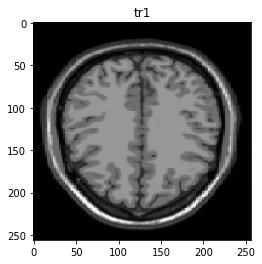

In [14]:
plt.title('tr1')
plt.imshow(sample_tr1[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

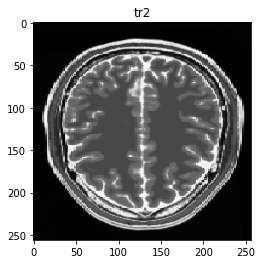

In [15]:
plt.title('tr2')
plt.imshow(sample_tr2[0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [16]:
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [17]:
def unet_generator():
    down_stack = [
        downsample(64, 4, False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(128, 4), # (bs, 32, 32, 128)
        downsample(128, 4), # (bs, 16, 16, 128)
        downsample(128, 4), # (bs, 8, 8, 128)
        downsample(128, 4), # (bs, 4, 4, 128)         
        downsample(128, 4), # (bs, 2, 2, 128)
        downsample(128, 4), # (bs, 1, 1, 128)
    ]
    up_stack = [
        upsample(128, 4, True), #(bs, 2, 2, 128)
        upsample(128, 4, True), #(bs, 4, 4, 128)
        upsample(128, 4), # (bs, 8, 8, 128)
        upsample(128, 4), # (bs, 16, 16, 128)
        upsample(128, 4), # (bs, 32, 32, 128)
        upsample(128, 4), # (b, 64, 64, 128)
        upsample(64, 4) # (b, 128, 128, 64)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[None, None, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
generator_g = unet_generator() #initialise the generator
generator_f = unet_generator() #initialise the generator

In [19]:
generator_g.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, None, None, 6 1024        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, None, None, 1 131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, None, None, 1 262400      sequential_1[0][0]               
_______________________________________________________________________________________

In [20]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4)(x) # (bs, 128, 128, 64) #write your code to downsample X
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128) #write your code to downsample down1
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 128) #write your code to downsample down2
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last) #create the model using input & output layer

In [21]:
discriminator_x = discriminator() #initialise the discriminator
discriminator_y = discriminator() #initialise the discriminator

In [22]:
discriminator_x.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, None, 1)]   0         
_________________________________________________________________
sequential_30 (Sequential)   (None, None, None, 64)    1152      
_________________________________________________________________
sequential_31 (Sequential)   (None, None, None, 128)   131328    
_________________________________________________________________
sequential_32 (Sequential)   (None, None, None, 256)   524800    
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, None, None, 256)   0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 512)   2097152   
_________________________________________________________________
instance_normalization_31 (I (None, None, None, 512)  

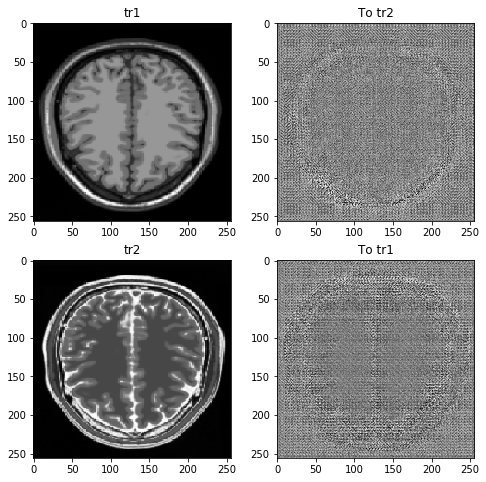

In [23]:
to_tr2 = generator_g(sample_tr1)
to_tr1 = generator_f(sample_tr2)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

In [24]:
LAMBDA = 1.0 #"Your Lambda Value Here"

In [25]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True) #"Your Binary-Cross-Entropy Loss Here"

In [26]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real) #write your code here
    generated_loss = loss_obj(tf.zeros_like(generated), generated) #write your code here
    total_disc_loss = real_loss+generated_loss #write your code here
    return total_disc_loss * 0.5

In [27]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [28]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image)) #write your code here
    return 10 * loss1 * LAMBDA

In [29]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss * LAMBDA

In [30]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [31]:
EPOCHS = 50 #"Your Number of Epochs Here"

In [32]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [33]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [34]:
total_cycle_loss_v = tf.keras.metrics.Mean('total_cycle_loss', dtype=tf.float32)
gen_g_loss_v = tf.keras.metrics.Mean('gen_g_loss', dtype=tf.float32)
gen_f_loss_v = tf.keras.metrics.Mean('gen_f_loss', dtype=tf.float32)
identity_loss_y_v = tf.keras.metrics.Mean('identity_loss_y', dtype=tf.float32)
identity_loss_x_v = tf.keras.metrics.Mean('total_gen_f_loss', dtype=tf.float32)
disc_x_loss_v = tf.keras.metrics.Mean('disc_x_loss', dtype=tf.float32)
disc_y_loss_v = tf.keras.metrics.Mean('disc_y_loss', dtype=tf.float32)

In [35]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True) #write your code to generate images using Generator_g on real_x
        cycled_x = generator_f(fake_y, training=True) #write your code to generate images susiing Generator_f on fake_y
        
        fake_x = generator_f(real_y, training = True) #write your code to generate images using Generator_f on real_y
        cycled_y = generator_g(fake_x, training = True) #write your code to generate images using Generator_g on fake_x
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training = True) #write your code to generate images using Generator_f on real_x
        same_y = generator_g(real_y, training = True) #write your code to generate images using Generator_g on real_y
        
        disc_real_x = discriminator_x(real_x, training = True) #write your code to discriminate images using Discriminator_x on real_x
        disc_real_y = discriminator_y(real_y, training = True) #write your code to discriminate images using Discriminator_y on real_y
        
        disc_fake_x = discriminator_x(fake_x, training = True) #write your code to discriminate images using Discriminator_x on fake_x
        disc_fake_y = discriminator_y(fake_y, training = True) #write your code to discriminate images using Discriminator_y on fake_y
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y) # calculate the generator_loss for disc_fake_
        gen_f_loss = generator_loss(disc_fake_x) # calculate the generator_loss for disc_fake_X 
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) #calculate the total cycle loss
        
        # Total generator loss = adversarial loss + cycle loss
        identity_loss_y = identity_loss(real_y, same_y)
        identity_loss_x = identity_loss(real_x, same_x)
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss_y
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss_x
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x) # calculate the discriminator_loss for disc_fake_x wrt disc_real_x
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y) # calculate the discriminator_loss foor disc_fake_y wrt disc_real_y
    
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables) #write your code here
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables) #write your code here
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables) #write your code here
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables) #write your code here
    
    # Apply the gradients to the optimizer
    
    #write your code here
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    # Tracking loss
    total_cycle_loss_v(total_cycle_loss)
    gen_g_loss_v(gen_g_loss)
    gen_f_loss_v(gen_f_loss)
    identity_loss_y_v(identity_loss_y)
    identity_loss_x_v(identity_loss_x)
    disc_x_loss_v(disc_x_loss)
    disc_y_loss_v(disc_y_loss)
    


Epoch 1
 total_gen_g_loss: 13.533720970153809
	gen_g_loss: 1.424339771270752 total_cycle_loss: 11.791984558105469 identity_loss_y: 0.3173966705799103
 total_gen_f_loss: 13.155319213867188
	gen_f_loss: 1.060205340385437 total_cycle_loss: 11.791984558105469 identity_loss_x: 0.30312952399253845
 disc_x_loss: 0.9927077293395996
 disc_y_loss: 1.0438730716705322


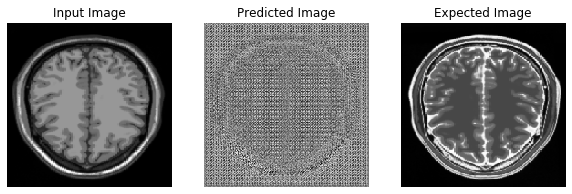

Saving checkpoint for epoch 0 at checkpoints/ckpt-1
Epoch 2
 total_gen_g_loss: 12.415192604064941
	gen_g_loss: 1.1974421739578247 total_cycle_loss: 10.910285949707031 identity_loss_y: 0.30746421217918396
 total_gen_f_loss: 12.219443321228027
	gen_f_loss: 1.0163873434066772 total_cycle_loss: 10.910285949707031 identity_loss_x: 0.2927703261375427
 disc_x_loss: 0.8753051161766052
 disc_y_loss: 0.8780203461647034


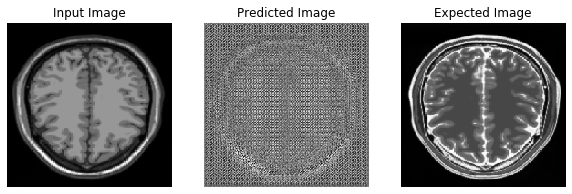

Saving checkpoint for epoch 1 at checkpoints/ckpt-2
Epoch 3
 total_gen_g_loss: 11.565183639526367
	gen_g_loss: 1.1796900033950806 total_cycle_loss: 10.089848518371582 identity_loss_y: 0.2956444025039673
 total_gen_f_loss: 11.370099067687988
	gen_f_loss: 1.000166416168213 total_cycle_loss: 10.089848518371582 identity_loss_x: 0.2800832688808441
 disc_x_loss: 0.7674334049224854
 disc_y_loss: 0.7964460849761963


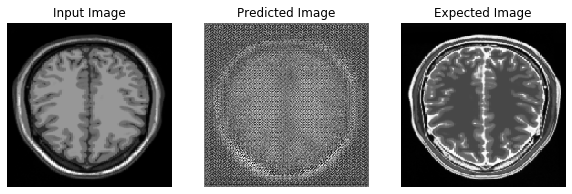

Saving checkpoint for epoch 2 at checkpoints/ckpt-3
Epoch 4
 total_gen_g_loss: 10.826407432556152
	gen_g_loss: 1.1446419954299927 total_cycle_loss: 9.399859428405762 identity_loss_y: 0.28190651535987854
 total_gen_f_loss: 10.69137191772461
	gen_f_loss: 1.026737928390503 total_cycle_loss: 9.399859428405762 identity_loss_x: 0.264774352312088
 disc_x_loss: 0.7127172946929932
 disc_y_loss: 0.7670629620552063


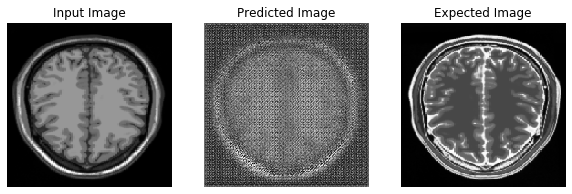

Saving checkpoint for epoch 3 at checkpoints/ckpt-4
Epoch 5
 total_gen_g_loss: 10.198861122131348
	gen_g_loss: 1.1293740272521973 total_cycle_loss: 8.80134391784668 identity_loss_y: 0.2681441009044647
 total_gen_f_loss: 10.090322494506836
	gen_f_loss: 1.0396631956100464 total_cycle_loss: 8.80134391784668 identity_loss_x: 0.24931567907333374
 disc_x_loss: 0.6623799800872803
 disc_y_loss: 0.7456477880477905


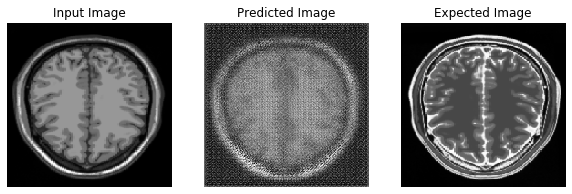

Saving checkpoint for epoch 4 at checkpoints/ckpt-5
Epoch 6
 total_gen_g_loss: 9.692934036254883
	gen_g_loss: 1.113267421722412 total_cycle_loss: 8.32632827758789 identity_loss_y: 0.25333747267723083
 total_gen_f_loss: 9.645110130310059
	gen_f_loss: 1.0859180688858032 total_cycle_loss: 8.32632827758789 identity_loss_x: 0.23286359012126923
 disc_x_loss: 0.6528353095054626
 disc_y_loss: 0.727337121963501


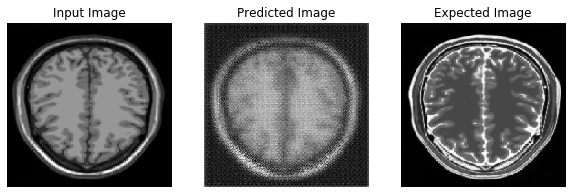

Saving checkpoint for epoch 5 at checkpoints/ckpt-6
Epoch 7
 total_gen_g_loss: 9.251105308532715
	gen_g_loss: 1.1255693435668945 total_cycle_loss: 7.886183261871338 identity_loss_y: 0.23935258388519287
 total_gen_f_loss: 9.217765808105469
	gen_f_loss: 1.1137070655822754 total_cycle_loss: 7.886183261871338 identity_loss_x: 0.21787534654140472
 disc_x_loss: 0.642019510269165
 disc_y_loss: 0.7467042207717896


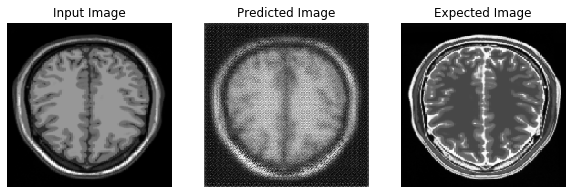

Saving checkpoint for epoch 6 at checkpoints/ckpt-7
Epoch 8
 total_gen_g_loss: 8.823265075683594
	gen_g_loss: 1.1156589984893799 total_cycle_loss: 7.480760097503662 identity_loss_y: 0.2268458604812622
 total_gen_f_loss: 8.802888870239258
	gen_f_loss: 1.1176851987838745 total_cycle_loss: 7.480760097503662 identity_loss_x: 0.2044443041086197
 disc_x_loss: 0.6228046417236328
 disc_y_loss: 0.7475283741950989


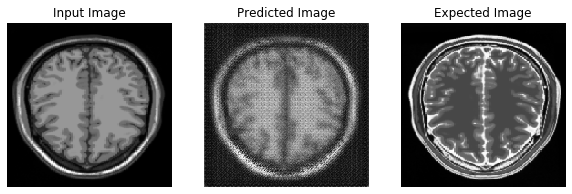

Saving checkpoint for epoch 7 at checkpoints/ckpt-8
Epoch 9
 total_gen_g_loss: 8.430018424987793
	gen_g_loss: 1.0883525609970093 total_cycle_loss: 7.125787258148193 identity_loss_y: 0.21587826311588287
 total_gen_f_loss: 8.428855895996094
	gen_f_loss: 1.1102415323257446 total_cycle_loss: 7.125787258148193 identity_loss_x: 0.19282738864421844
 disc_x_loss: 0.6245481967926025
 disc_y_loss: 0.7371143102645874


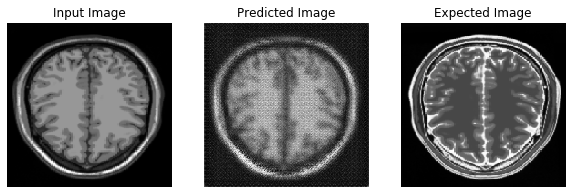

Saving checkpoint for epoch 8 at checkpoints/ckpt-9
Epoch 10
 total_gen_g_loss: 8.069329261779785
	gen_g_loss: 1.0687260627746582 total_cycle_loss: 6.794692039489746 identity_loss_y: 0.205910786986351
 total_gen_f_loss: 8.103544235229492
	gen_f_loss: 1.1264712810516357 total_cycle_loss: 6.794692039489746 identity_loss_x: 0.1823805421590805
 disc_x_loss: 0.6432222723960876
 disc_y_loss: 0.7283381819725037


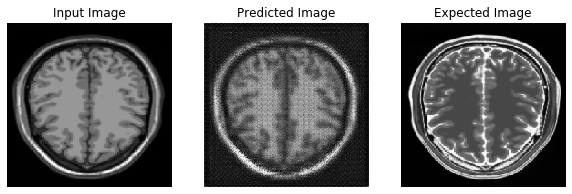

Saving checkpoint for epoch 9 at checkpoints/ckpt-10
Epoch 11
 total_gen_g_loss: 7.759100437164307
	gen_g_loss: 1.0586422681808472 total_cycle_loss: 6.503020763397217 identity_loss_y: 0.19743724167346954
 total_gen_f_loss: 7.7897443771362305
	gen_f_loss: 1.1135215759277344 total_cycle_loss: 6.503020763397217 identity_loss_x: 0.17320211231708527
 disc_x_loss: 0.648801326751709
 disc_y_loss: 0.7257232666015625


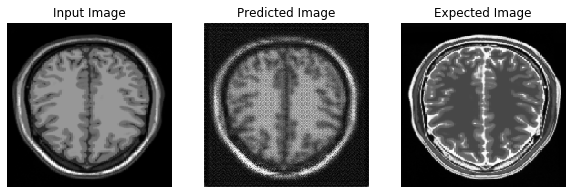

Saving checkpoint for epoch 10 at checkpoints/ckpt-11
Epoch 12
 total_gen_g_loss: 7.474233150482178
	gen_g_loss: 1.048387050628662 total_cycle_loss: 6.236082077026367 identity_loss_y: 0.1897641271352768
 total_gen_f_loss: 7.499873161315918
	gen_f_loss: 1.0988211631774902 total_cycle_loss: 6.236082077026367 identity_loss_x: 0.16496998071670532
 disc_x_loss: 0.6471917033195496
 disc_y_loss: 0.7205941081047058


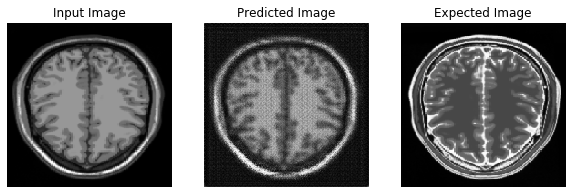

Saving checkpoint for epoch 11 at checkpoints/ckpt-12
Epoch 13
 total_gen_g_loss: 7.21344518661499
	gen_g_loss: 1.0363547801971436 total_cycle_loss: 5.99428129196167 identity_loss_y: 0.182809516787529
 total_gen_f_loss: 7.247147560119629
	gen_f_loss: 1.0952857732772827 total_cycle_loss: 5.99428129196167 identity_loss_x: 0.15758056938648224
 disc_x_loss: 0.6480808258056641
 disc_y_loss: 0.7132008671760559


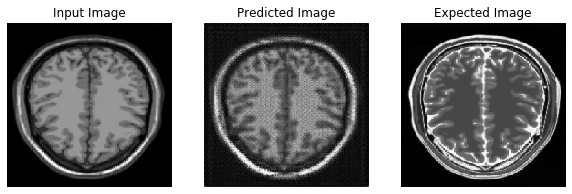

Saving checkpoint for epoch 12 at checkpoints/ckpt-13
Epoch 14
 total_gen_g_loss: 6.97880220413208
	gen_g_loss: 1.0308562517166138 total_cycle_loss: 5.771452903747559 identity_loss_y: 0.17649298906326294
 total_gen_f_loss: 7.013452053070068
	gen_f_loss: 1.0910457372665405 total_cycle_loss: 5.771452903747559 identity_loss_x: 0.1509535163640976
 disc_x_loss: 0.6453952789306641
 disc_y_loss: 0.707526683807373


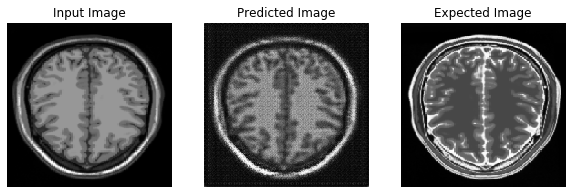

Saving checkpoint for epoch 13 at checkpoints/ckpt-14
Epoch 15
 total_gen_g_loss: 6.763132095336914
	gen_g_loss: 1.0221426486968994 total_cycle_loss: 5.57014274597168 identity_loss_y: 0.17084695398807526
 total_gen_f_loss: 6.80509614944458
	gen_f_loss: 1.0899454355239868 total_cycle_loss: 5.57014274597168 identity_loss_x: 0.1450078785419464
 disc_x_loss: 0.6440415978431702
 disc_y_loss: 0.7020032405853271


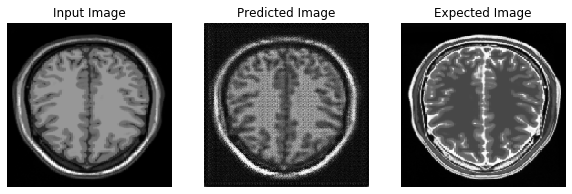

Saving checkpoint for epoch 14 at checkpoints/ckpt-15
Epoch 16
 total_gen_g_loss: 6.570497035980225
	gen_g_loss: 1.0174247026443481 total_cycle_loss: 5.387399196624756 identity_loss_y: 0.16567344963550568
 total_gen_f_loss: 6.613935470581055
	gen_f_loss: 1.0869015455245972 total_cycle_loss: 5.387399196624756 identity_loss_x: 0.13963454961776733
 disc_x_loss: 0.640474259853363
 disc_y_loss: 0.6958968043327332


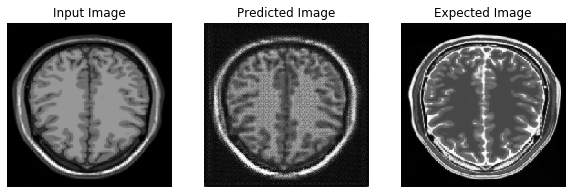

Saving checkpoint for epoch 15 at checkpoints/ckpt-16
Epoch 17
 total_gen_g_loss: 6.396360397338867
	gen_g_loss: 1.015488862991333 total_cycle_loss: 5.220029830932617 identity_loss_y: 0.16084177792072296
 total_gen_f_loss: 6.4402265548706055
	gen_f_loss: 1.085392713546753 total_cycle_loss: 5.220029830932617 identity_loss_x: 0.13480380177497864
 disc_x_loss: 0.639838695526123
 disc_y_loss: 0.6893197894096375


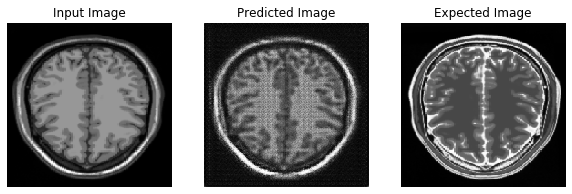

Saving checkpoint for epoch 16 at checkpoints/ckpt-17
Epoch 18
 total_gen_g_loss: 6.240248203277588
	gen_g_loss: 1.0155116319656372 total_cycle_loss: 5.068375587463379 identity_loss_y: 0.15636098384857178
 total_gen_f_loss: 6.283872604370117
	gen_f_loss: 1.0850666761398315 total_cycle_loss: 5.068375587463379 identity_loss_x: 0.13042999804019928
 disc_x_loss: 0.6359260082244873
 disc_y_loss: 0.6845276355743408


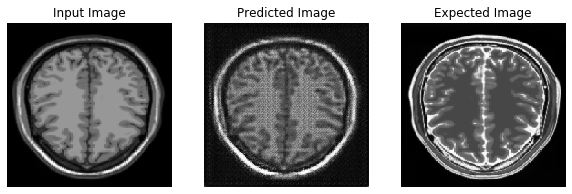

Saving checkpoint for epoch 17 at checkpoints/ckpt-18
Epoch 19
 total_gen_g_loss: 6.094809055328369
	gen_g_loss: 1.0156738758087158 total_cycle_loss: 4.92693567276001 identity_loss_y: 0.15219907462596893
 total_gen_f_loss: 6.138513088226318
	gen_f_loss: 1.0851258039474487 total_cycle_loss: 4.92693567276001 identity_loss_x: 0.12645146250724792
 disc_x_loss: 0.6332546472549438
 disc_y_loss: 0.6797617673873901


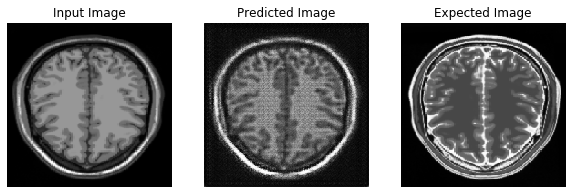

Saving checkpoint for epoch 18 at checkpoints/ckpt-19
Epoch 20
 total_gen_g_loss: 5.961213111877441
	gen_g_loss: 1.016469955444336 total_cycle_loss: 4.79639196395874 identity_loss_y: 0.14835117757320404
 total_gen_f_loss: 6.0032525062561035
	gen_f_loss: 1.0840494632720947 total_cycle_loss: 4.79639196395874 identity_loss_x: 0.1228107437491417
 disc_x_loss: 0.6298595666885376
 disc_y_loss: 0.6742517948150635


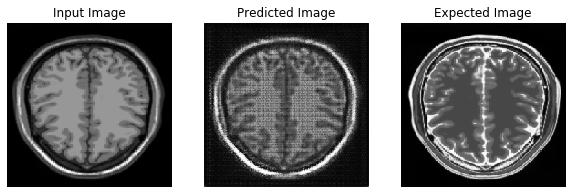

Saving checkpoint for epoch 19 at checkpoints/ckpt-20
Epoch 21
 total_gen_g_loss: 5.838989734649658
	gen_g_loss: 1.0164660215377808 total_cycle_loss: 4.677750587463379 identity_loss_y: 0.14477281272411346
 total_gen_f_loss: 5.87824010848999
	gen_f_loss: 1.08100426197052 total_cycle_loss: 4.677750587463379 identity_loss_x: 0.11948560178279877
 disc_x_loss: 0.6263784766197205
 disc_y_loss: 0.6685970425605774


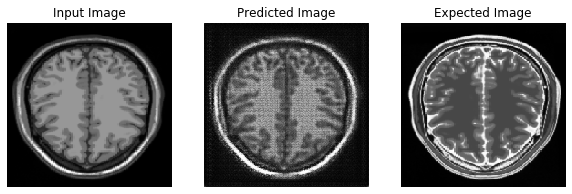

Saving checkpoint for epoch 20 at checkpoints/ckpt-21
Epoch 22
 total_gen_g_loss: 5.728844165802002
	gen_g_loss: 1.0192030668258667 total_cycle_loss: 4.568239688873291 identity_loss_y: 0.1414014846086502
 total_gen_f_loss: 5.762789249420166
	gen_f_loss: 1.0780984163284302 total_cycle_loss: 4.568239688873291 identity_loss_x: 0.11645142734050751
 disc_x_loss: 0.6229352355003357
 disc_y_loss: 0.6634795665740967


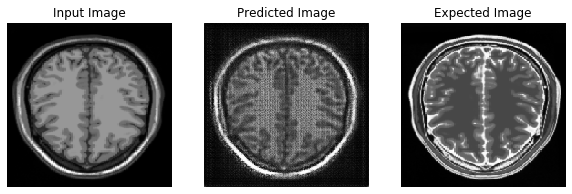

Saving checkpoint for epoch 21 at checkpoints/ckpt-22
Epoch 23
 total_gen_g_loss: 5.623776435852051
	gen_g_loss: 1.0194766521453857 total_cycle_loss: 4.465965747833252 identity_loss_y: 0.1383344531059265
 total_gen_f_loss: 5.65413761138916
	gen_f_loss: 1.0744855403900146 total_cycle_loss: 4.465965747833252 identity_loss_x: 0.1136866882443428
 disc_x_loss: 0.6196821928024292
 disc_y_loss: 0.6596336960792542


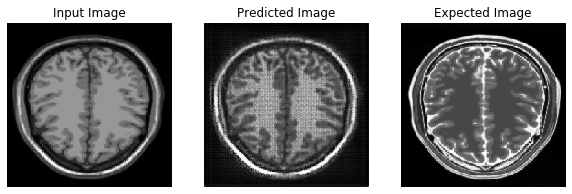

Saving checkpoint for epoch 22 at checkpoints/ckpt-23
Epoch 24
 total_gen_g_loss: 5.527484893798828
	gen_g_loss: 1.0203970670700073 total_cycle_loss: 4.371637344360352 identity_loss_y: 0.13545046746730804
 total_gen_f_loss: 5.55363130569458
	gen_f_loss: 1.0708634853363037 total_cycle_loss: 4.371637344360352 identity_loss_x: 0.11113010346889496
 disc_x_loss: 0.6168683171272278
 disc_y_loss: 0.6549890637397766


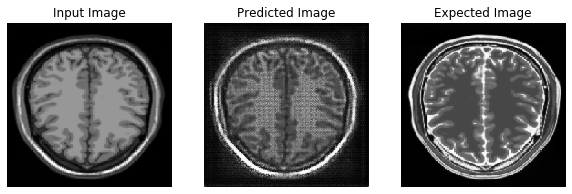

Saving checkpoint for epoch 23 at checkpoints/ckpt-24
Epoch 25
 total_gen_g_loss: 5.436129570007324
	gen_g_loss: 1.0225235223770142 total_cycle_loss: 4.280799865722656 identity_loss_y: 0.13280630111694336
 total_gen_f_loss: 5.457035064697266
	gen_f_loss: 1.067449688911438 total_cycle_loss: 4.280799865722656 identity_loss_x: 0.10878562927246094
 disc_x_loss: 0.6144843101501465
 disc_y_loss: 0.6495121121406555


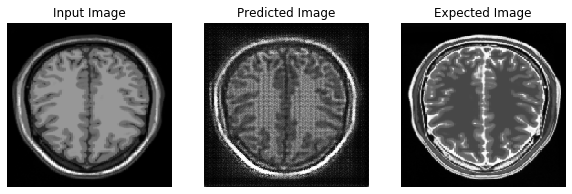

Saving checkpoint for epoch 24 at checkpoints/ckpt-25
Epoch 26
 total_gen_g_loss: 5.349147796630859
	gen_g_loss: 1.0226072072982788 total_cycle_loss: 4.196159362792969 identity_loss_y: 0.13038107752799988
 total_gen_f_loss: 5.365519046783447
	gen_f_loss: 1.0626956224441528 total_cycle_loss: 4.196159362792969 identity_loss_x: 0.10666416585445404
 disc_x_loss: 0.6131767630577087
 disc_y_loss: 0.6456550359725952


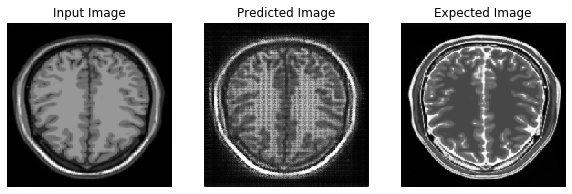

Saving checkpoint for epoch 25 at checkpoints/ckpt-26
Epoch 27
 total_gen_g_loss: 5.276750087738037
	gen_g_loss: 1.0226106643676758 total_cycle_loss: 4.1260271072387695 identity_loss_y: 0.1281125396490097
 total_gen_f_loss: 5.293467044830322
	gen_f_loss: 1.0627529621124268 total_cycle_loss: 4.1260271072387695 identity_loss_x: 0.10468704253435135
 disc_x_loss: 0.6151261329650879
 disc_y_loss: 0.6425475478172302


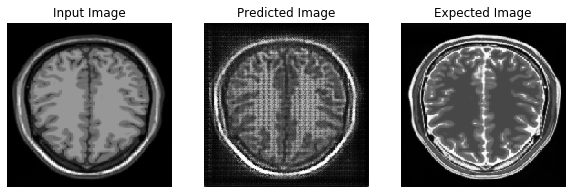

Saving checkpoint for epoch 26 at checkpoints/ckpt-27
Epoch 28
 total_gen_g_loss: 5.204198360443115
	gen_g_loss: 1.0229533910751343 total_cycle_loss: 4.055339336395264 identity_loss_y: 0.1259053647518158
 total_gen_f_loss: 5.215531349182129
	gen_f_loss: 1.0573809146881104 total_cycle_loss: 4.055339336395264 identity_loss_x: 0.10281072556972504
 disc_x_loss: 0.6143257021903992
 disc_y_loss: 0.6408801078796387


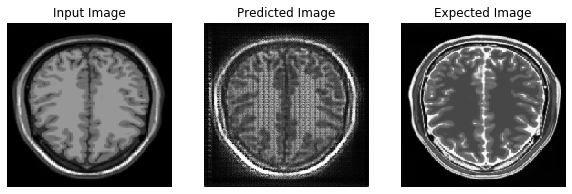

Saving checkpoint for epoch 27 at checkpoints/ckpt-28
Epoch 29
 total_gen_g_loss: 5.134472370147705
	gen_g_loss: 1.0229861736297607 total_cycle_loss: 3.987612247467041 identity_loss_y: 0.12387420237064362
 total_gen_f_loss: 5.143383502960205
	gen_f_loss: 1.0546883344650269 total_cycle_loss: 3.987612247467041 identity_loss_x: 0.101082943379879
 disc_x_loss: 0.6142879128456116
 disc_y_loss: 0.6382136344909668


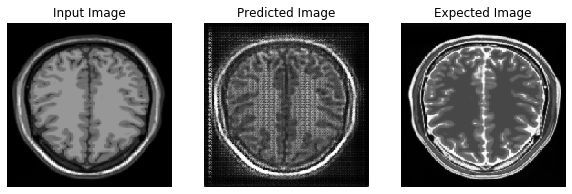

Saving checkpoint for epoch 28 at checkpoints/ckpt-29
Epoch 30
 total_gen_g_loss: 5.068760395050049
	gen_g_loss: 1.0221679210662842 total_cycle_loss: 3.9246199131011963 identity_loss_y: 0.12197253108024597
 total_gen_f_loss: 5.07379150390625
	gen_f_loss: 1.0496742725372314 total_cycle_loss: 3.9246199131011963 identity_loss_x: 0.09949742257595062
 disc_x_loss: 0.6149843335151672
 disc_y_loss: 0.6350482106208801


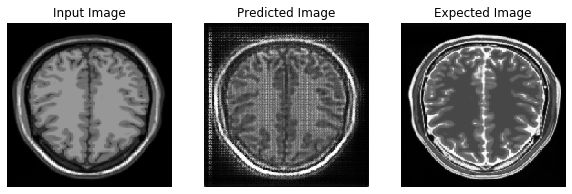

Saving checkpoint for epoch 29 at checkpoints/ckpt-30
Epoch 31
 total_gen_g_loss: 5.012501239776611
	gen_g_loss: 1.025214433670044 total_cycle_loss: 3.867177963256836 identity_loss_y: 0.12010892480611801
 total_gen_f_loss: 5.009629249572754
	gen_f_loss: 1.0444386005401611 total_cycle_loss: 3.867177963256836 identity_loss_x: 0.09801283478736877
 disc_x_loss: 0.6152974367141724
 disc_y_loss: 0.6336267590522766


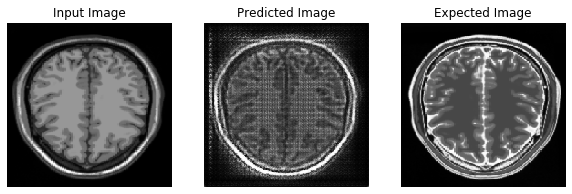

Saving checkpoint for epoch 30 at checkpoints/ckpt-31
Epoch 32
 total_gen_g_loss: 4.9582133293151855
	gen_g_loss: 1.025931715965271 total_cycle_loss: 3.8139374256134033 identity_loss_y: 0.11834453791379929
 total_gen_f_loss: 4.951380729675293
	gen_f_loss: 1.040831446647644 total_cycle_loss: 3.8139374256134033 identity_loss_x: 0.0966121032834053
 disc_x_loss: 0.6162276864051819
 disc_y_loss: 0.633696973323822


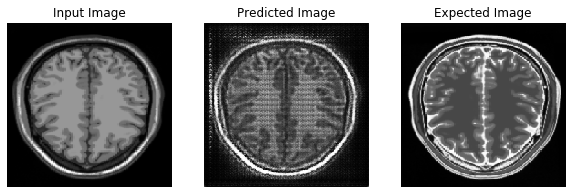

Saving checkpoint for epoch 31 at checkpoints/ckpt-32
Epoch 33
 total_gen_g_loss: 4.9010138511657715
	gen_g_loss: 1.0250252485275269 total_cycle_loss: 3.7592475414276123 identity_loss_y: 0.11674100905656815
 total_gen_f_loss: 4.890787601470947
	gen_f_loss: 1.0362849235534668 total_cycle_loss: 3.7592475414276123 identity_loss_x: 0.09525516629219055
 disc_x_loss: 0.6158652901649475
 disc_y_loss: 0.6317427754402161


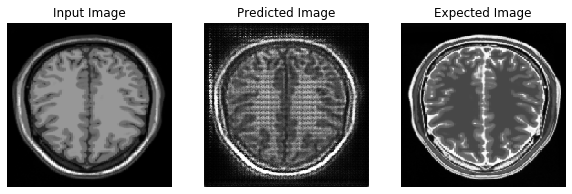

Saving checkpoint for epoch 32 at checkpoints/ckpt-33
Epoch 34
 total_gen_g_loss: 4.847137451171875
	gen_g_loss: 1.0262885093688965 total_cycle_loss: 3.705643653869629 identity_loss_y: 0.11520525068044662
 total_gen_f_loss: 4.833012580871582
	gen_f_loss: 1.0334001779556274 total_cycle_loss: 3.705643653869629 identity_loss_x: 0.09396887570619583
 disc_x_loss: 0.6157620549201965
 disc_y_loss: 0.6288998126983643


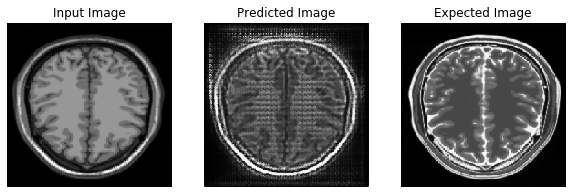

Saving checkpoint for epoch 33 at checkpoints/ckpt-34
Epoch 35
 total_gen_g_loss: 4.7968034744262695
	gen_g_loss: 1.0260989665985107 total_cycle_loss: 3.65695858001709 identity_loss_y: 0.11374574154615402
 total_gen_f_loss: 4.780647277832031
	gen_f_loss: 1.0308946371078491 total_cycle_loss: 3.65695858001709 identity_loss_x: 0.09279417246580124
 disc_x_loss: 0.6160249710083008
 disc_y_loss: 0.6267932653427124


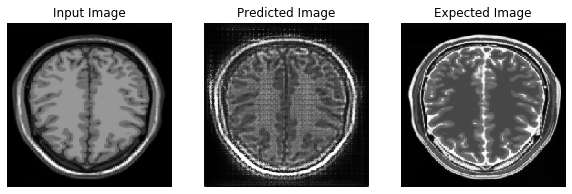

Saving checkpoint for epoch 34 at checkpoints/ckpt-35
Epoch 36
 total_gen_g_loss: 4.747113227844238
	gen_g_loss: 1.0255235433578491 total_cycle_loss: 3.6092679500579834 identity_loss_y: 0.11232198774814606
 total_gen_f_loss: 4.727837085723877
	gen_f_loss: 1.0269564390182495 total_cycle_loss: 3.6092679500579834 identity_loss_x: 0.09161291271448135
 disc_x_loss: 0.6154926419258118
 disc_y_loss: 0.6248447299003601


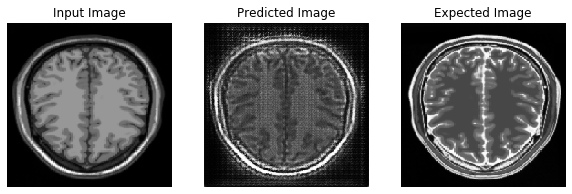

Saving checkpoint for epoch 35 at checkpoints/ckpt-36
Epoch 37
 total_gen_g_loss: 4.7002458572387695
	gen_g_loss: 1.0246130228042603 total_cycle_loss: 3.5646331310272217 identity_loss_y: 0.11099940538406372
 total_gen_f_loss: 4.680253028869629
	gen_f_loss: 1.0250850915908813 total_cycle_loss: 3.5646331310272217 identity_loss_x: 0.09053467959165573
 disc_x_loss: 0.6155945658683777
 disc_y_loss: 0.6230005025863647


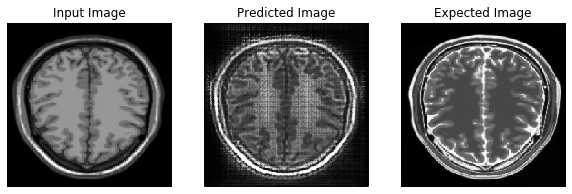

Saving checkpoint for epoch 36 at checkpoints/ckpt-37
Epoch 38
 total_gen_g_loss: 4.652680397033691
	gen_g_loss: 1.0240604877471924 total_cycle_loss: 3.518918037414551 identity_loss_y: 0.10970223695039749
 total_gen_f_loss: 4.630733966827393
	gen_f_loss: 1.0223541259765625 total_cycle_loss: 3.518918037414551 identity_loss_x: 0.08946158736944199
 disc_x_loss: 0.6153976321220398
 disc_y_loss: 0.6211256980895996


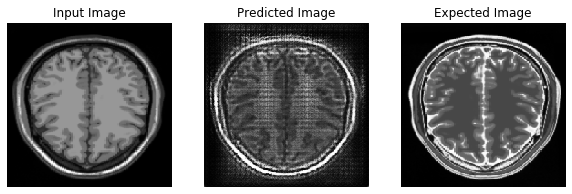

Saving checkpoint for epoch 37 at checkpoints/ckpt-38
Epoch 39
 total_gen_g_loss: 4.609095573425293
	gen_g_loss: 1.0236865282058716 total_cycle_loss: 3.476902723312378 identity_loss_y: 0.10850640386343002
 total_gen_f_loss: 4.585616111755371
	gen_f_loss: 1.020249843597412 total_cycle_loss: 3.476902723312378 identity_loss_x: 0.08846372365951538
 disc_x_loss: 0.6150803565979004
 disc_y_loss: 0.6192646622657776


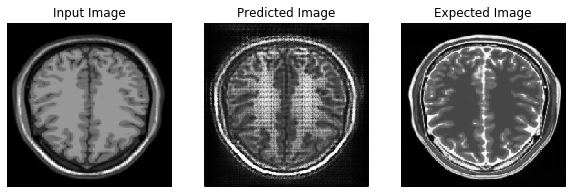

Saving checkpoint for epoch 38 at checkpoints/ckpt-39
Epoch 40
 total_gen_g_loss: 4.568706035614014
	gen_g_loss: 1.0244468450546265 total_cycle_loss: 3.4369077682495117 identity_loss_y: 0.10735152661800385
 total_gen_f_loss: 4.542410850524902
	gen_f_loss: 1.017998218536377 total_cycle_loss: 3.4369077682495117 identity_loss_x: 0.08750490844249725
 disc_x_loss: 0.615208089351654
 disc_y_loss: 0.6182963848114014


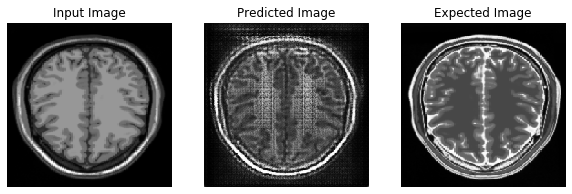

Saving checkpoint for epoch 39 at checkpoints/ckpt-40
Epoch 41
 total_gen_g_loss: 4.527942657470703
	gen_g_loss: 1.0252420902252197 total_cycle_loss: 3.3964669704437256 identity_loss_y: 0.10623368620872498
 total_gen_f_loss: 4.5001068115234375
	gen_f_loss: 1.0170567035675049 total_cycle_loss: 3.3964669704437256 identity_loss_x: 0.08658307045698166
 disc_x_loss: 0.6153120398521423
 disc_y_loss: 0.6165881752967834


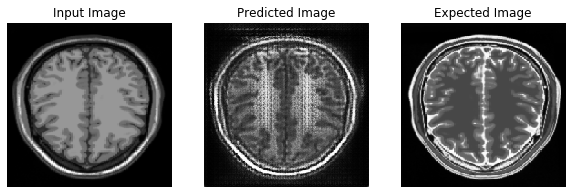

Saving checkpoint for epoch 40 at checkpoints/ckpt-41
Epoch 42
 total_gen_g_loss: 4.489373207092285
	gen_g_loss: 1.0256847143173218 total_cycle_loss: 3.3585147857666016 identity_loss_y: 0.1051735132932663
 total_gen_f_loss: 4.45790433883667
	gen_f_loss: 1.0136712789535522 total_cycle_loss: 3.3585147857666016 identity_loss_x: 0.08571796119213104
 disc_x_loss: 0.6155433654785156
 disc_y_loss: 0.6149808168411255


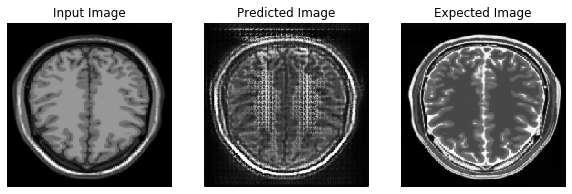

Saving checkpoint for epoch 41 at checkpoints/ckpt-42
Epoch 43
 total_gen_g_loss: 4.449751853942871
	gen_g_loss: 1.0249989032745361 total_cycle_loss: 3.320633888244629 identity_loss_y: 0.10411927849054337
 total_gen_f_loss: 4.418464660644531
	gen_f_loss: 1.01297926902771 total_cycle_loss: 3.320633888244629 identity_loss_x: 0.08485109359025955
 disc_x_loss: 0.6151025891304016
 disc_y_loss: 0.6131324172019958


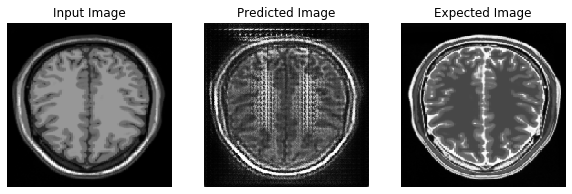

Saving checkpoint for epoch 42 at checkpoints/ckpt-43
Epoch 44
 total_gen_g_loss: 4.411601543426514
	gen_g_loss: 1.0245598554611206 total_cycle_loss: 3.2839062213897705 identity_loss_y: 0.10313571244478226
 total_gen_f_loss: 4.3789238929748535
	gen_f_loss: 1.0109673738479614 total_cycle_loss: 3.2839062213897705 identity_loss_x: 0.0840500071644783
 disc_x_loss: 0.6150412559509277
 disc_y_loss: 0.6116460561752319


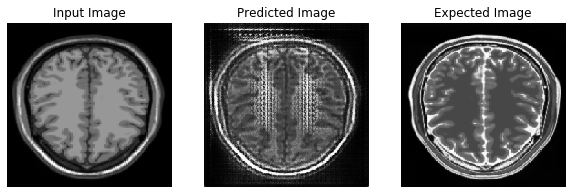

Saving checkpoint for epoch 43 at checkpoints/ckpt-44
Epoch 45
 total_gen_g_loss: 4.3772783279418945
	gen_g_loss: 1.024950623512268 total_cycle_loss: 3.2501540184020996 identity_loss_y: 0.1021738275885582
 total_gen_f_loss: 4.341945171356201
	gen_f_loss: 1.008480429649353 total_cycle_loss: 3.2501540184020996 identity_loss_x: 0.08331052958965302
 disc_x_loss: 0.614983081817627
 disc_y_loss: 0.6109317541122437


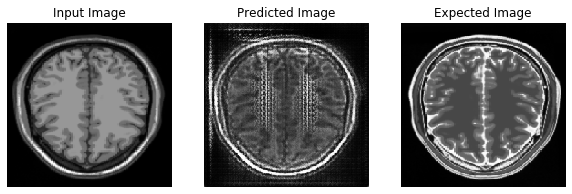

Saving checkpoint for epoch 44 at checkpoints/ckpt-45
Epoch 46
 total_gen_g_loss: 4.3417649269104
	gen_g_loss: 1.023747205734253 total_cycle_loss: 3.2167649269104004 identity_loss_y: 0.10125315189361572
 total_gen_f_loss: 4.306884765625
	gen_f_loss: 1.007534146308899 total_cycle_loss: 3.2167649269104004 identity_loss_x: 0.08258559554815292
 disc_x_loss: 0.6151930689811707
 disc_y_loss: 0.610364556312561


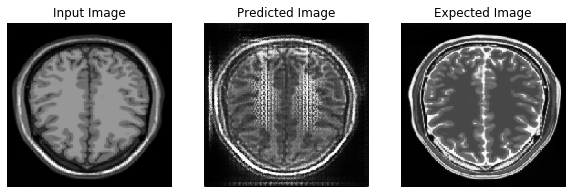

Saving checkpoint for epoch 45 at checkpoints/ckpt-46
Epoch 47
 total_gen_g_loss: 4.3107523918151855
	gen_g_loss: 1.0244890451431274 total_cycle_loss: 3.1859073638916016 identity_loss_y: 0.10035631060600281
 total_gen_f_loss: 4.2750163078308105
	gen_f_loss: 1.0072170495986938 total_cycle_loss: 3.1859073638916016 identity_loss_x: 0.08189206570386887
 disc_x_loss: 0.6144108176231384
 disc_y_loss: 0.6088835000991821


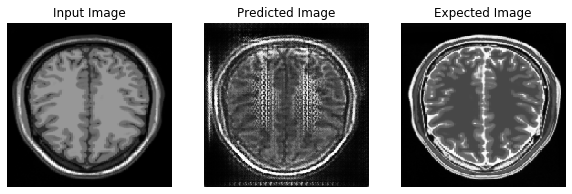

Saving checkpoint for epoch 46 at checkpoints/ckpt-47
Epoch 48
 total_gen_g_loss: 4.278434753417969
	gen_g_loss: 1.024983286857605 total_cycle_loss: 3.1539723873138428 identity_loss_y: 0.09947928786277771
 total_gen_f_loss: 4.239649772644043
	gen_f_loss: 1.004474401473999 total_cycle_loss: 3.1539723873138428 identity_loss_x: 0.08120319992303848
 disc_x_loss: 0.6135929226875305
 disc_y_loss: 0.607387363910675


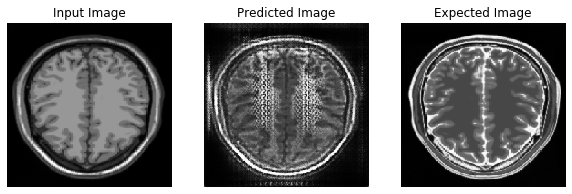

Saving checkpoint for epoch 47 at checkpoints/ckpt-48
Epoch 49
 total_gen_g_loss: 4.245951175689697
	gen_g_loss: 1.0241957902908325 total_cycle_loss: 3.123112916946411 identity_loss_y: 0.09864217042922974
 total_gen_f_loss: 4.206986904144287
	gen_f_loss: 1.0033057928085327 total_cycle_loss: 3.123112916946411 identity_loss_x: 0.08056852966547012
 disc_x_loss: 0.6127390265464783
 disc_y_loss: 0.6068151593208313


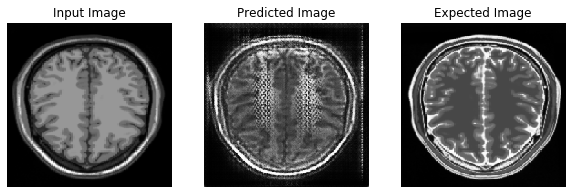

Saving checkpoint for epoch 48 at checkpoints/ckpt-49
Epoch 50
 total_gen_g_loss: 4.215533256530762
	gen_g_loss: 1.0240379571914673 total_cycle_loss: 3.093662738800049 identity_loss_y: 0.09783274680376053
 total_gen_f_loss: 4.176464080810547
	gen_f_loss: 1.002859115600586 total_cycle_loss: 3.093662738800049 identity_loss_x: 0.07994243502616882
 disc_x_loss: 0.6121324896812439
 disc_y_loss: 0.6062659621238708


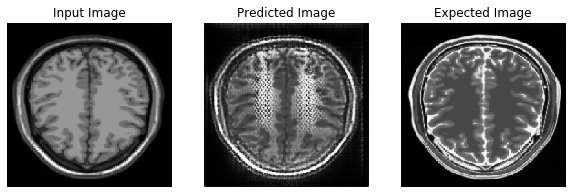

Saving checkpoint for epoch 49 at checkpoints/ckpt-50


In [36]:
for epoch in range(EPOCHS):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    total_gen_g_loss_t = gen_g_loss_v.result() + total_cycle_loss_v.result() + identity_loss_y_v.result()
    total_gen_f_loss_t = gen_f_loss_v.result() + total_cycle_loss_v.result() + identity_loss_x_v.result()
    template = 'Epoch {}\n total_gen_g_loss: {}\n\tgen_g_loss: {} total_cycle_loss: {} identity_loss_y: {}\n total_gen_f_loss: {}\n\tgen_f_loss: {} total_cycle_loss: {} identity_loss_x: {}\n disc_x_loss: {}\n disc_y_loss: {}'
    print(template.format(epoch+1,total_gen_g_loss_t,gen_g_loss_v.result(), total_cycle_loss_v.result(), identity_loss_y_v.result(),
                          total_gen_f_loss_t,gen_f_loss_v.result(),total_cycle_loss_v.result(),identity_loss_x_v.result(),
                          disc_x_loss_v.result(), disc_y_loss_v.result()))
    generate_images(generator_g, sample_tr1, sample_tr2)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

### Run the trained model on the test dataset

In [37]:
# Dataset which has been uploaded in the nimblebox has been used
dir_name_tr1 = 'dataset/Tr1/TrainT1/'
dir_name_tr2 = 'dataset/Tr2/TrainT2/'
images = ['Image #70.png','Image #93.png','Image #113.png']
tr1_iamges = [dir_name_tr1+img for img in images]
tr2_iamges = [dir_name_tr2+img for img in images]

In [38]:
tr1_img = np.array([np.array(tf.keras.preprocessing.image.load_img(fname,color_mode="grayscale",target_size=(img_height,img_height)),dtype=np.float32) for fname in tr1_iamges])
tr1_img = tr1_img.reshape(tr1_img.shape[0], img_height, img_width, 1)
tr1_img = tf.data.Dataset.from_tensor_slices(tr1_img).batch(1)
tr1_img = tr1_img.map(preprocess_image_train)

In [39]:
tr2_img = np.array([np.array(tf.keras.preprocessing.image.load_img(fname,color_mode="grayscale",target_size=(img_height,img_height)),dtype=np.float32) for fname in tr2_iamges])
tr2_img = tr2_img.reshape(tr2_img.shape[0], img_height, img_width, 1)
tr2_img = tf.data.Dataset.from_tensor_slices(tr2_img).batch(1)
tr2_img = tr2_img.map(preprocess_image_train)

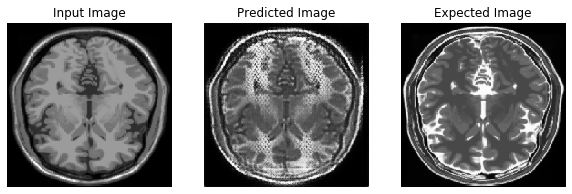

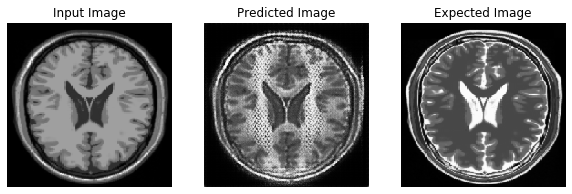

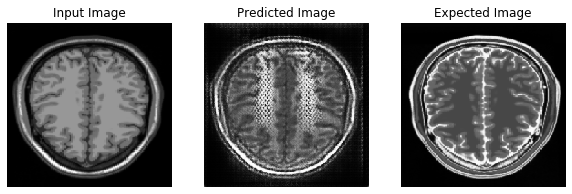

In [40]:
# Run the trained model on the test dataset
for inp,out in zip(tr1_img.take(3), tr2_img.take(3)):
    generate_images(generator_g, inp, out)

## Different approach comparison

<table>
    <tr style="font-weight:bold;text-align:center">
        <td style="text-align:left">Seq No</td>
        <td style="text-align:left">Model Description</td>
        <td style="text-align:left">Comments</td>
        <td style="text-align:left">Loss Metric</td>
        <td style="text-align:left">Next Steps</td>
<!--         <td style="text-align:center">50th Epoch Image</td> -->
    </tr>
    <tr>
        <td style="text-align:left">1</td>
        <td style="text-align:left"> 
            <ul>
                <li> Tried without lambda in loss function </li>
                <li>with 50 epochs</li>
                <li>batch size 32</li>
            </ul>
        </td>
        <td style="text-align:left">Out of memory error</td>
        <td style="text-align:left">NA</td>
        <td style="text-align:left">Try to batch size 16</td>
<!--         <td >Didn't capture at this moment</td> -->
    </tr>
    <tr>
        <td style="text-align:left">2</td>
        <td style="text-align:left">
            <ul>
                <li>Tried without lambda in loss function </li>
                <li>with 50 epochs</li>
                <li>batch size 16</li>
            </ul>
        </td>
        <td style="text-align:left">Training completed succesfully</td>
        <td style="text-align:left">Didn't capture at this moment</td>
        <td style="text-align:left" width="300">Since key features in the image is still resembling TR1. This means generator is not able to fool discriminator very well. Thought of experiementing with lambda</td>
<!--         <td >Didn't capture at this moment</td> -->
    </tr>
    <tr>
        <td style="text-align:left">3</td>
        <td style="text-align:left" width="200">
            <ul>
                <li>with 0.01 lambda in loss function</li>
                <li> batch size and epoch as above
                <li>with 256 filters in 3rd layer of discriminator</li>
            </ul>
        </td>
        <td style="text-align:left" width="200">Very poor result. Model result is toggling between best to worst.</td>
        <td style="text-align:left">Didn't capture at this moment</td>
        <td style="text-align:left" width="280">Since key features in the image is still resembling TR1. This means generator is not able to fool discriminator very well. Thought of experiementing with lambda</td>
<!--         <td >Didn't capture at this moment</td> -->
    </tr>
    <tr>
        <td style="text-align:left">4</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 5.0 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100">The generator loss is very high</td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 13.194204330444336 </li> 
                <li>total_gen_f_loss: 13.08312702178955 </li> 
                <li>disc_x_loss: 0.4721892774105072 </li>
                <li>disc_y_loss: 0.4684845507144928 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Decreasing lambda value</td>
<!--         <td >Didn't capture at this moment</td> -->
    </tr>
    <tr>
        <td style="text-align:left">5</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 0.5 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="200">Since the generator loss decreased</td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 2.613384246826172 </li> 
                <li>total_gen_f_loss: 2.54666805267334, </li> 
                <li>disc_x_loss: 0.6479595899581909 </li>
                <li>disc_y_loss: 0.6406314373016357 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Decreasing lambda value further</td>
<!--         <td >Didn't capture at this moment</td> -->
    </tr>
    <tr>
        <td style="text-align:left">6</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 0.1 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100">Generatot loss decreased but image produced is of very poor quality</td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 1.5017011165618896, </li> 
                <li>total_gen_f_loss: 1.3227537870407104, </li> 
                <li>disc_x_loss: 0.6720079779624939 </li>
                <li>disc_y_loss: 0.6126081943511963 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">After trying different combinations of lambda value finally thought of sticking to 1.0 as of now</td>
<!--         <td ><img src="image/0.1lambda.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">7</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 1.0 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>Image generated is better than 0.1 lambda value </li>
                <li>but discriminator loss is high compared to 5.0 lambda value.</li>
                <li>Although discriminator loss is better than 0.5 lambda value</li>
            </ul>
        </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.7450215816497803, </li> 
                <li>total_gen_f_loss: 3.678227186203003, </li> 
                <li>disc_x_loss: 0.6283600926399231 </li>
                <li>disc_y_loss: 0.6085248589515686 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Trying 1.2 lambda value to have further improvement in discriminator loss.</td>
<!--         <td ><img src="image/1.0lambda.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">8</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 1.2 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>Generator loss increased </li>
                <li>Discriminator Loss decreased </li>
                <li>Output Image is little hazy.</li>
            </ul>
        </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 4.4170684814453125, </li> 
                <li>total_gen_f_loss: 4.359621047973633, </li> 
                <li>disc_x_loss: 0.6044492721557617, </li>
                <li>disc_y_loss: 0.5847496390342712 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Since Predicted image is hazy planning to use 0.8 lambda value</td>
<!--         <td ><img src="image/1.2lambda.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">9</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 0.8 lambda in loss function</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100"> Doesn't performed better than 1.0 lambda when comparing images.</td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.185190439224243, </li> 
                <li>total_gen_f_loss: 3.1634488105773926, </li> 
                <li>disc_x_loss: 0.6384435296058655, </li>
                <li>disc_y_loss: 0.632077157497406 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planned to tune other hyper-parameters like kernel size</td>
<!--         <td ><img src="image/0.8lambda.png" style="width:500px;height:150px;" /></td> -->
    </tr>
        <tr>
        <td style="text-align:left">10</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 1.0 lambda in loss function</li>
                <li>used kernel size of 2 instead of 4 in down stack and up_stack</li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100"> Hazy Image with reduced kernel size. </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.971024513244629, </li> 
                <li>total_gen_f_loss: 3.8833467960357666, </li> 
                <li>disc_x_loss: 0.6120151877403259,</li>
                <li>disc_y_loss: 0.5572025775909424 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planned to increase fiters for some layers in downstack and upstack</td>
<!--         <td ><img src="image/kernel2.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">11</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 1.0 lambda in loss function</li>
                <li>kernel size back to 4 in down stack and up_stack</li>
                <li>Increased number of neurons to 256 in 1 layer each in downstack and upstack of generator </li>
                <li>Batch size reduced to 8 to run this archirecture </li>
                <li> others as above </li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Loss decreased and predicted image is little sharper but trainable weights increased to double. Hence not planning to use this architecture as low level features are still not improving </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.077288866043091, </li> 
                <li>total_gen_f_loss: 3.0044925212860107, </li> 
                <li>disc_x_loss: 0.6330186128616333,</li>
                <li>disc_y_loss: 0.5974542498588562 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planning to read how to improve low level features</td>
<!--         <td ><img src="image/filter256.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">12</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 1.0 lambda in loss function</li>
                <li>with 75 epoch</li>
                <li> Number of neurons are brought down to 128 again from 256 </li>
                <li>Printing each loss function separately</li>
                <li>Batch size increased to 16 again </li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100"> Running for more number of epochs is not making much difference as loss is decreasing very slowly after 50th epoch anyways </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.35760498046875, gen_g_loss: 0.9816992282867432 total_cycle_loss: 2.301997184753418  identity_loss_y: 0.07390868663787842</li>
                <li>total_gen_f_loss: 3.302259683609009, gen_f_loss: 0.9371173977851868 total_cycle_loss: 2.301997184753418  identity_loss_x: 0.06314516067504883</li>
                <li>disc_x_loss: 0.6333508491516113,</li>
                <li>disc_y_loss: 0.6013396382331848 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planning to read how to improve low level features</td>
<!--         <td ><img src="image/epoch50.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">13</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>with 50 epoch</li>
                <li>using a learning rate of 0.00002 instead of 0.0002 </li>
                <li> others as above
            </ul>
        </td>
        <td style="text-align:left" width="100"> Images are blurry </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 8.679535865783691, gen_g_loss: 0.9403119087219238 total_cycle_loss: 7.535178184509277  identity_loss_y: 0.20404542982578278</li>
                <li>total_gen_f_loss: 8.746281623840332, gen_f_loss: 1.0385218858718872 total_cycle_loss: 7.535178184509277  identity_loss_x: 0.17258195579051971</li>
                <li>disc_x_loss: 0.5075154900550842,</li>
                <li>disc_y_loss: 0.5765727758407593 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planning to use 0.002 learning rate</td>
<!--         <td ><img src="image/learningrate0.00002.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">14</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>using a learning rate of 0.002 instead of 0.0002 </li>
                <li>run for only 7 epochs</li>
                <li> others as above </li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Images are completly different than the expected one </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 6.74, gen_g_loss: 1.94 total_cycle_loss: 4.46  identity_loss_y: 0.34</li>
                <li>total_gen_f_loss: 6.79, gen_f_loss: 1.95 total_cycle_loss: 4.46  identity_loss_x: 0.37</li>
                <li>disc_x_loss: 1.20,</li>
                <li>disc_y_loss: 1.21 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180"></td>
<!--         <td ><img src="image/learningrate0.002.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">15</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>using a learning rate of 0.0002 as before </li>
                <li>Running for 50 epochs</li>
                <li>Set bias to true for most of layers of discriminator </li>
                <li>Removed Instance normlization in the first layer of discriminator</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Doesn't made much difference. Low level features are still not converting properly </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 4.1610565185546875, gen_g_loss: 1.0657261610031128 total_cycle_loss: 3.004210948944092 identity_loss_y: 0.0911191925406456</li>
                <li>total_gen_f_loss: 6.79, gen_f_loss: 1.95 total_cycle_loss: 3.004210948944092 identity_loss_x: 0.07555349171161652</li>
                <li>disc_x_loss: 0.6100088953971863,</li>
                <li>disc_y_loss: 0.572725236415863 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Thinking of increasing the number of filters for each layer now in generator. Also remove zero padding in discriminator and set 0.02 in leaky relu</td>
<!--         <td ><img src="image/biasindiscriminator.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">16</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>Removed zero padding layers in discriminator </li>
                <li>Set 0.02 as alpha in leaky relu</li>
                <li>Set bias to true for most of layers of discriminator </li>
                <li>Removed Instance normlization in the first layer of discriminator</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Loss increased. Image is also not sharp. </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 5.430668830871582, gen_g_loss: 1.4045497179031372 total_cycle_loss: 3.911973476409912 identity_loss_y: 0.1141456738114357</li>
                <li>total_gen_f_loss: 5.199162483215332, gen_f_loss: 1.1991482973098755 total_cycle_loss: 3.911973476409912 identity_loss_x: 0.08804059773683548</li>
                <li>disc_x_loss: 0.5445454120635986,</li>
                <li>disc_y_loss: 0.4869527220726013 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Lets increase the number of filters in generator layers </td>
<!--         <td ><img src="image/16.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">17</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>Added zero padding layers in discriminator </li>
                <li>Set alpha to default in leaky relu</li>
                <li>Set bias to false </li>
                <li>Added Instance normlization in the first layer of discriminator as well</li>
                <li>Made 2 layers to have 256 filters both in downstack and upstack of generator</li>
                <li>Also removed dropout from upstack in generator</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Not seeing much improvment </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 4.35233211517334, gen_g_loss: 1.142906665802002 total_cycle_loss: 3.1181108951568604 identity_loss_y: 0.09131425619125366</li>
                <li>total_gen_f_loss: 4.326464653015137, gen_f_loss: 1.1319636106491089 total_cycle_loss: 3.1181108951568604 identity_loss_x: 0.07639047503471375</li>
                <li>disc_x_loss: 0.5547201037406921,</li>
                <li>disc_y_loss: 0.5554022789001465 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Lets increase number of neurons/filters some more</td>
<!--         <td ><img src="image/17.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">18</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>Made 2 layers to have 256 filters both in downstack and upstack of generator. Also added some 512 filter layers</li>
                <li>Added dropout from upstack in generator</li>
                <li>Rest are same as above</li>
                <li>Run for 37 epochs</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Not seeing much improvment </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 4.638908386230469, gen_g_loss: 1.1537652015686035 total_cycle_loss: 3.377171039581299 identity_loss_y: 0.10797210037708282</li>
                <li>total_gen_f_loss: 4.529632091522217, gen_f_loss: 1.0720582008361816 total_cycle_loss: 3.377171039581299 identity_loss_x: 0.08040287345647812</li>
                <li>disc_x_loss: 0.5805106163024902,</li>
                <li>disc_y_loss: 0.5779128074645996 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Planning to stick to model 7 and reduce some layers in generators</td>
<!--         <td ><img src="image/18.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">19</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>Deleted some layer from the original setup in generator (i.e. exp 7)</li>
                <li>lambda value to 0.8</li>
                <li>Rest are same as exp 7</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Getting not very similar result what I got using more layers.  </td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 3.2167747020721436, gen_g_loss: 0.9769800901412964 total_cycle_loss: 2.1689233779907227 identity_loss_y: 0.07087106257677078</li>
                <li>total_gen_f_loss: 3.1970019340515137, gen_f_loss: 0.972413957118988 total_cycle_loss: 2.1689233779907227 identity_loss_x: 0.05566463991999626</li>
                <li>disc_x_loss: 0.6358051896095276,</li>
                <li>disc_y_loss: 0.62032151222229 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Still try to reduce layers further and use different lambda value</td>
<!--         <td ><img src="image/19.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">20</td>
        <td style="text-align:left" width="150">
            <ul>
                <li>Keeping only 3 layers each in downstack and upstack</li>
                <li>Lambda to 1.0</li>
                <li>Rest are same as above</li>
            </ul>
        </td>
        <td style="text-align:left" width="100"> Images are not very sharp but in this architecture as well lambda of 1.0 performed the best</td>
        <td style="text-align:left" width="100">
            <ul>
                <li>total_gen_g_loss: 4.1476826667785645, gen_g_loss: 1.09219491481781 total_cycle_loss: 2.957869291305542 identity_loss_y: 0.09761869162321091</li>
                <li>total_gen_f_loss: 3.036181926727295, gen_f_loss: 1.0065627098083496 total_cycle_loss: 2.957869291305542 identity_loss_x: 0.0717499852180481</li>
                <li>disc_x_loss: 0.6209999918937683,</li>
                <li>disc_y_loss: 0.598872721195221 </li>
            </ul>
        </td>
        <td style="text-align:left" width="180">Changing number of filter in each layer</td>
<!--         <td ><img src="image/20.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    <tr>
        <td style="text-align:left">21</td>
        <td style="text-align:left" width="300">
            <ul>
                <li>Keeping only 3 layers each in downstack and upstack but increased number of filters</li>
                <li>Lambda to 1.0</li>
                <li>Rest are same as above</li>
            </ul>
        </td>
        <td style="text-align:left" width="200"> Not good images</td>
        <td style="text-align:left" width="200">
            <ul>
                <li>total_gen_g_loss: 3.692087173461914, gen_g_loss: 1.0074321031570435 total_cycle_loss: 2.6024210453033447 identity_loss_y: 0.08223386853933334</li>
                <li>total_gen_f_loss: 3.667726516723633, gen_f_loss: 0.9975631833076477 total_cycle_loss: 2.6024210453033447 identity_loss_x: 0.06774231791496277</li>
                <li>disc_x_loss: 0.5997612476348877,</li>
                <li>disc_y_loss: 0.6156721115112305 </li>
            </ul>
        </td>
        <td style="text-align:left" width="250">Planning to stick to exp 7 setup</td>
<!--         <td ><img src="image/21.png" style="width:500px;height:150px;" /></td> -->
    </tr>
    
    
</table>